# 调用实现CNN

training data =  (50000, 32, 32, 3)
testing data =  (10000, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)   

390/390 - 154s - loss: 0.9737 - accuracy: 0.6716 - val_loss: 0.9578 - val_accuracy: 0.6843 - 154s/epoch - 395ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 0.95784
390/390 - 154s - loss: 0.9574 - accuracy: 0.6753 - val_loss: 1.0122 - val_accuracy: 0.6734 - 154s/epoch - 394ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.95784
390/390 - 154s - loss: 0.9371 - accuracy: 0.6821 - val_loss: 0.9646 - val_accuracy: 0.6825 - 154s/epoch - 396ms/step
79/79 [==============================] - 7s 92ms/step - loss: 0.9646 - accuracy: 0.6825

Test result: 68.250 loss: 0.965


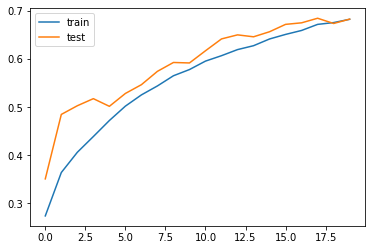

In [1]:
from keras.datasets import cifar10
 
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import optimizers
import numpy as np

# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
print("training data = ", x_train.shape)
print("testing data = ", x_test.shape)

# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
# let's look at the normalized values of a sample image
x_train[0]

# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras
from keras.utils import to_categorical
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
 
# let's display one of the one-hot encoded labels
y_train[0]

# build the model
 
# number of hidden units variable
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32
 
# l2 regularization hyperparameter
weight_decay = 1e-4
 
# instantiate an empty sequential model
model = Sequential()
 
# CONV1
# notice that we defined the input_shape here because this is the first CONV layer.
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
# print model summary
model.summary()

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
 
# compute the data augmentation on the training set
datagen.fit(x_train)

 
# training
from tensorflow.keras.optimizers import legacy
batch_size = 128
epochs=20
 
checkpointer = ModelCheckpoint(filepath='model.125epochs.hdf5', verbose=1, save_best_only=True)
 
# you can try any of these optimizers by uncommenting the line
#optimizer = rmsprop(lr=0.001,decay=1e-6)
optimizer = legacy.Adam(learning_rate=0.0001,decay=1e-6)
 
#optimizer =keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))


# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# plot learning curves of model accuracy
 
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()